<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-23 07:37:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-04-23 07:37:44 (11.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



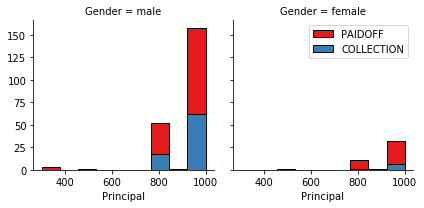

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

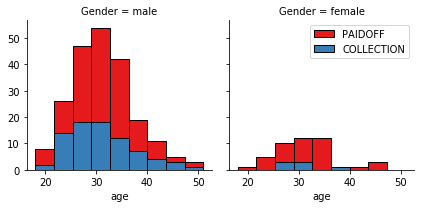

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

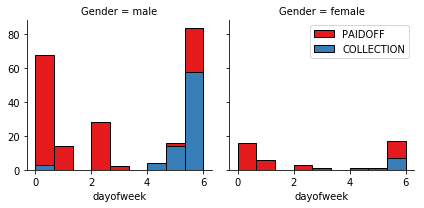

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Let's look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loans.


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Let's define the feature set X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization gives data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)

In [22]:
# Ensuring that our training and test (validation) data have similar numbers of defaults

perc_train = len([1 for item in y_train if item == 'COLLECTION'])/len(y_train) * 100
perc_test = len([1 for item in y_test if item == 'COLLECTION'])/len(y_test) * 100

print('The percentage of defaults in the training data is: ', perc_train)
print('The percentage of defaults in the test data is: ', perc_test)

The percentage of defaults in the training data is:  24.324324324324326
The percentage of defaults in the test data is:  26.436781609195403


These percentages are fairly close together, so I'll go ahead and move on to the next step, which is choosing a value of ```k``` for the KNN model.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def eval_for_k(k, X, y, X_valid, y_valid):
    
    knn_class = KNeighborsClassifier(n_neighbors = k)
    knn_class.fit(X,y)
    
    y_pred = knn_class.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    
    return acc
    

In [24]:
scores = []

for k in range(2, 10):
    score = eval_for_k(k, X_train, y_train, X_test, y_test)
    scores.append(score)
    
print('The best value for k is: ', np.argmax(scores)+2)


The best value for k is:  3


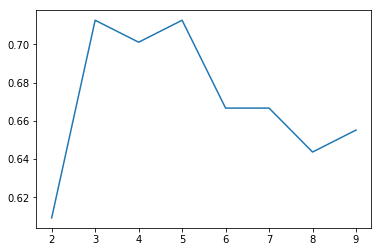

In [25]:
# And a graph

plt.plot(range(2, 10), scores)

And now, to fit a KNN classifier with 3 groups to the entirety of my data

In [26]:
KNN_class = KNeighborsClassifier(n_neighbors = 3)
KNN_class.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

### KNN model evaluation on the Training Set

I will compute F1 and JSS scores for the __test set__ on the KNN model below, after loading and preprocessing the data. Here, I compute the F1 score and JSS score for the KNN model on the *training set*, which we expect to be better than one would obtain with the test set.

In [27]:
# KNN predictions on the training set

knn_pred_train = KNN_class.predict(X)

In [28]:
# Computing a weighted f1 score for k nearest neighbors

f1_collections = f1_score(y, knn_pred_train, pos_label = "COLLECTION")
f1_paidoff = f1_score(y, knn_pred_train, pos_label = "PAIDOFF")

weight_collections = list(y).count("COLLECTION")/len(list(y))
weight_paidoff = list(y).count("PAIDOFF")/len(list(y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(y, knn_pred_train)

# And printing the results

print('The training JSS for KNN is: ', JSS)
print('The (weighted) training f1 score for KNN is: ', weighted_f1)



The training JSS for KNN is:  0.815028901734104
The (weighted) training f1 score for KNN is:  0.8052183805075044


# Decision Tree

Since we're fitting only a single decision tree here, there is little (or nothing) to tune.

In [29]:
from sklearn.tree import DecisionTreeClassifier

DT_class = DecisionTreeClassifier(random_state = 27)
DT_class.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=27,
            splitter='best')

### Decision Tree model evaluation on the Training Set

I will compute F1 and JSS scores for the __test set__ on the Decision Tree model below, after loading and preprocessing the data. Here, I compute the F1 score and JSS score for the Decision Tree model on the *training set*, which we expect to be better than one would obtain with the test set.

In [30]:
# Decision Tree predictions on the training set

DT_pred_train = DT_class.predict(X)

In [31]:
# Computing a weighted f1 score for decision tree

f1_collections = f1_score(y, DT_pred_train, pos_label = "COLLECTION")
f1_paidoff = f1_score(y, DT_pred_train, pos_label = "PAIDOFF")

weight_collections = list(y).count("COLLECTION")/len(list(y))
weight_paidoff = list(y).count("PAIDOFF")/len(list(y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(y, DT_pred_train)

# And printing the results

print('The training JSS for Decision Tree is: ', JSS)
print('The (weighted) training f1 score for Decision Tree is: ', weighted_f1)




The training JSS for Decision Tree is:  0.8930635838150289
The (weighted) training f1 score for Decision Tree is:  0.8957643129154805


# Support Vector Machine

In [32]:
from sklearn.svm import SVC

Let's experiment a bit with different kernel types and different degrees for the polynomial kernel.

In [33]:
def best_SVC(X, y, X_valid, y_valid, ker, deg = 0):
    
    find_SVC = SVC(kernel = ker, degree = deg)
    find_SVC.fit(X, y)
    
    y_pred = find_SVC.predict(X_valid)
    
    acc = accuracy_score(y_valid, y_pred)

    return acc

In [34]:
scores = {}

kernels_to_try = [['linear', 0], ['poly', 2], ['poly', 3], ['poly', 4], ['rbf', 0], ['sigmoid', 0]]

for i in range(len(kernels_to_try)):
    name = kernels_to_try[i][0] + str(kernels_to_try[i][1])
    score = best_SVC(X_train, y_train, X_test, y_test, kernels_to_try[i][0], kernels_to_try[i][1])
    scores[name] = score
    
print('The best kernel combination is', max(scores, key = scores.get))

The best kernel combination is linear0


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packa

In [35]:
scores

{'linear0': 0.735632183908046,
 'poly2': 0.735632183908046,
 'poly3': 0.7126436781609196,
 'poly4': 0.7126436781609196,
 'rbf0': 0.7241379310344828,
 'sigmoid0': 0.6896551724137931}

Since this suggests that the best kernel for this data (based on a validation set) is a linear kernel, we will fit a linesr kernel model to the entire training dataset.

In [36]:
SV_class = SVC(kernel = 'linear', probability = True)
SV_class.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Support Vector Machine model evaluation on the Training Set

I will compute F1, JSS, and log-loss scores for the __test set__ on the Support Vector Machine model below, after loading and preprocessing the data. Here, I compute the F1 score and JSS score for the Support Vector Machine model on the *training set*, which we expect to be better than one would obtain with the test set.

In [37]:
# Support Vector Machine predictions on the training set

SV_pred_train = SV_class.predict(X)
SV_pred_prob_train = SV_class.predict_proba(X)

In [38]:
# Computing a weighted f1 score for the Support Vector Machine

f1_collections = f1_score(y, SV_pred_train, pos_label = "COLLECTION")
f1_paidoff = f1_score(y, SV_pred_train, pos_label = "PAIDOFF")

weight_collections = list(y).count("COLLECTION")/len(list(y))
weight_paidoff = list(y).count("PAIDOFF")/len(list(y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(y, SV_pred_train)

# Computing the log-loss

LL = log_loss(y, SV_pred_prob_train)

# And printing the results

print('The training JSS for SV is: ', JSS)
print('The (weighted) training f1 score for SV is: ', weighted_f1)
print('The training log-loss for SV is: ', LL)

The training JSS for SV is:  0.7514450867052023
The (weighted) training f1 score for SV is:  0.6448043648295465
The training log-loss for SV is:  0.5608183796022332


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression

Once again here, there isn't really anything to tune, so I'll just go ahead and fit to all of my training data from the beginning.

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
LR_class = LogisticRegression(random_state = 27)
LR_class.fit(X, y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Logistic Regression model evaluation on the Training Set

I will compute F1, JSS, and log-loss scores for the __test set__ on the Logistic Regression model below, after loading and preprocessing the data. Here, I compute the F1 score and JSS score for the Logistic Regression model on the *training set*, which we expect to be better than one would obtain with the test set.

In [41]:
# Logistic Regression predictions on the training set

LR_pred_train = LR_class.predict(X)
LR_pred_prob_train = LR_class.predict_proba(X)

In [42]:
# Computing a weighted f1 score for Logistic Regression

f1_collections = f1_score(y, LR_pred_train, pos_label = "COLLECTION")
f1_paidoff = f1_score(y, LR_pred_train, pos_label = "PAIDOFF")

weight_collections = list(y).count("COLLECTION")/len(list(y))
weight_paidoff = list(y).count("PAIDOFF")/len(list(y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(y, LR_pred_train)

# Computing the log-loss

LL = log_loss(y, LR_pred_prob_train)

# And printing the results

print('The training JSS for SV is: ', JSS)
print('The (weighted) training f1 score for SV is: ', weighted_f1)
print('The training log-loss for SV is: ', LL)

The training JSS for SV is:  0.7543352601156069
The (weighted) training f1 score for SV is:  0.6997291283105058
The training log-loss for SV is:  0.433946460100774


# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-23 07:40:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-23 07:40:41 (184 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Preprocessing of the Test Data (to match the training data)

Note that while I used ```X_test```, ```y_test```, ```X_train```, and ```y_train``` as the train-test set for fitting parameters above, I use below ```test_X``` and ```test_y``` as names for my testing data.

In [46]:
# Converting dates to datetime format

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [47]:
# Extracting day of week and whether or not the day falls on a weekend

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [48]:
# Making gender quantitative

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [49]:
# Feature selection

Feature = test_df[['Principal','terms','age','Gender','weekend']]

# One hot encoding of the education column
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)

# Dropping the "Master or Above" column because it's linearly dependent on the other education columns
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [50]:
# Separating the features and responses

test_X = Feature
test_y = test_df['loan_status'].values

In [51]:
# scaling the datat

test_X = preprocessing.StandardScaler().fit(X).transform(test_X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


## Calculating the evaluation metrics for KNN on the Test Set

In [52]:
# KNN predictions on the test set

knn_pred = KNN_class.predict(test_X)

In [53]:
# Computing a weighted f1 score for k nearest neighbors

f1_collections = f1_score(test_y, knn_pred, pos_label = "COLLECTION")
f1_paidoff = f1_score(test_y, knn_pred, pos_label = "PAIDOFF")

weight_collections = list(test_y).count("COLLECTION")/len(list(test_y))
weight_paidoff = list(test_y).count("PAIDOFF")/len(list(test_y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(test_y, knn_pred)

# And printing the results

print('The test JSS for KNN is: ', JSS)
print('The (weighted) test f1 score for KNN is: ', weighted_f1)


The test JSS for KNN is:  0.6111111111111112
The (weighted) test f1 score for KNN is:  0.5619412515964239


## Calculating the Evaluation Metrics for the Decision Tree on the Test Set

In [54]:
dt_pred_test = DT_class.predict(test_X)

In [55]:
# Computing a weighted f1 score for the decision tree

f1_collections = f1_score(test_y, dt_pred_test, pos_label = "COLLECTION")
f1_paidoff = f1_score(test_y, dt_pred_test, pos_label = "PAIDOFF")

weight_collections = list(test_y).count("COLLECTION")/len(list(test_y))
weight_paidoff = list(test_y).count("PAIDOFF")/len(list(test_y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(test_y, dt_pred_test)

# And printing the results

print('The test JSS for Decision Tree is: ', JSS)
print('The (weighted) test f1 score for Decision Tree is: ', weighted_f1)

The test JSS for Decision Tree is:  0.5740740740740741
The (weighted) test f1 score for Decision Tree is:  0.5988805707115566


## Calculating the Evaluation Metrics for SVM on the Test Set

In [56]:
sv_pred_test = SV_class.predict(test_X)
sv_pred_prob_test = SV_class.predict_proba(test_X)

In [57]:
# Computing a weighted f1 score for the support vector machine

f1_collections = f1_score(test_y, sv_pred_test, pos_label = "COLLECTION")
f1_paidoff = f1_score(test_y, sv_pred_test, pos_label = "PAIDOFF")

weight_collections = list(test_y).count("COLLECTION")/len(list(y_test))
weight_paidoff = list(test_y).count("PAIDOFF")/len(list(y_test))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(test_y, sv_pred_test)

# Computing the log-loss

LL = log_loss(test_y, sv_pred_prob_test)

# And printing the results

print('The test JSS for SVM is: ', JSS)
print('The (weighted) test f1 score for SVM is: ', weighted_f1)
print('The test log-loss score for SVM is: ', LL)

The test JSS for SVM is:  0.7407407407407407
The (weighted) test f1 score for SVM is:  0.3912937148447053
The test log-loss score for SVM is:  0.5733809479950311


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Calculating the Evaluation Metrics for Logistic Regression on the Test Set

In [58]:
lr_pred_test = LR_class.predict(test_X)
lr_pred_prob_test = LR_class.predict_proba(test_X)

In [59]:
# Computing a weighted f1 score for the support vector machine

f1_collections = f1_score(test_y, lr_pred_test, pos_label = "COLLECTION")
f1_paidoff = f1_score(test_y, lr_pred_test, pos_label = "PAIDOFF")

weight_collections = list(test_y).count("COLLECTION")/len(list(test_y))
weight_paidoff = list(test_y).count("PAIDOFF")/len(list(test_y))

weighted_f1 = f1_collections * weight_collections + f1_paidoff * weight_paidoff

# Computing the jaccard similarity score

JSS = jaccard_similarity_score(test_y, lr_pred_test)

# Computing the log-loss

LL = log_loss(test_y, lr_pred_prob_test)

# And printing the results

print('The JSS for Logistic Regression is: ', JSS)
print('The f1 score for Logistic Regression is: ', weighted_f1)
print('The log-loss score for Logistic Regression is: ', LL)

The JSS for Logistic Regression is:  0.25925925925925924
The f1 score for Logistic Regression is:  0.10675381263616557
The log-loss score for Logistic Regression is:  14.806457706947592


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |   0.6111     | 0.5619        | NA      |
| Decision Tree      | 0.5741   |  0.5989        | NA      |
| SVM                | 0.7407       | 0.6304        | 0.5734      |
| LogisticRegression | 0.2593       |   0.1068     | 14.8065       |

Looking at these results, it appears that the __Support Vector Machine__ fairs the best on unseen data, while __Logistic Regression__ performs the worst.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>